In [1]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.special import softmax
# from utils import denoise_text, preprocess_text

from sklearn.metrics import auc, roc_curve, RocCurveDisplay
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, 
    f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay)

from IPython.display import display, Markdown, Latex

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
FILE = "datasets/cards_waterloo_augmented.csv"

In [3]:
data = pd.read_csv(FILE, low_memory=False)

In [4]:
# Load label encoder
with open('cards/models/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

In [5]:
# data.loc[(data.DATASET.isin(["cards", "waterloo"])), "pos_roberta_pred"] = le.inverse_transform(
#     new_data.loc[(new_data.DATASET.isin(["cards", "waterloo"])), "pos_roberta_pred"].apply(int))
# data.loc[(data.DATASET.isin(["cards", "waterloo"])), "pos_roberta_proba"] = new_data.loc[
#     (new_data.DATASET.isin(["cards", "waterloo"])), "pos_roberta_proba"]

# data.to_csv(FILE, index=False)

In [6]:
def format_scores(x):
    if str(x)!="nan":
        return np.array(eval(re.sub(",? +", " ,", str(x).replace("\n", ""))))
    return

data["cards_proba"] = data["cards_proba"].apply(format_scores)
data["waterloo_proba"] = data["waterloo_proba"].apply(format_scores)
# data["roberta_cards_pipe_proba"] = data["roberta_cards_pipe_proba"].apply(format_scores)
data["roberta_proba"] = data["roberta_proba"].apply(format_scores)
data["bertweet_proba"] = data["bertweet_proba"].apply(format_scores)
data["electra_proba"] = data["electra_proba"].apply(format_scores)
data["xlnet_proba"] = data["xlnet_proba"].apply(format_scores)
# data["aug_roberta_proba"] = data["aug_roberta_proba"].apply(format_scores)

### Test Dataset

cards_binary
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5750
           1       0.79      0.72      0.76      1549

    accuracy                           0.90      7299
   macro avg       0.86      0.84      0.85      7299
weighted avg       0.90      0.90      0.90      7299

roberta
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5750
           1       0.88      0.83      0.85      1549

    accuracy                           0.94      7299
   macro avg       0.92      0.90      0.91      7299
weighted avg       0.94      0.94      0.94      7299



,Model,AUC,Accuracy,F1-score
0,cards_binary,0.655364,0.901630,0.848022
0,roberta,0.886856,0.939581,0.907602


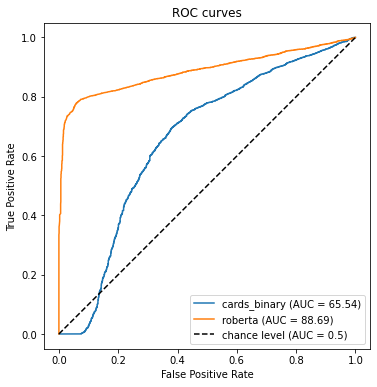

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/generated_disinformation_binary_TEST_CHATGPT.csv'

In [7]:
def add_binary_cards(data):
    data["cards_binary_pred"] = data["cards_pred"].apply(
        lambda x: 0 if x=="0_0" or x=='0.0' else 1)
    data["cards_binary_proba"] = data["cards_proba"].apply(lambda x: [x[0], sum(x[1:])])
    return data

def models_comparative(data, models):
    labels = [0, 1]
    target_names = ["Not Misinformation", "Misinformation"]
    freport = pd.DataFrame()
    
    plt.figure(figsize=(8, 6))
    for model in models:
        print(model)
        y_true = data.labels.values
        y_pred = data[f"{model}_pred"].values

        scores = data.apply(lambda x: x[f"{model}_proba"][int(x[f"{model}_pred"])], axis=1).values
        fpr, tpr, thresholds = roc_curve(data.labels, scores)    
        roc_auc = auc(tpr, fpr)# multi_class="ovr", average="macro")
        plt.plot(tpr, fpr, label=f"{model} (AUC = {round(roc_auc*100, 2)})")

        acc = accuracy_score(y_true, y_pred)
        print(classification_report(y_true, y_pred, labels=labels))

        report = {
            "Model": model,
            "AUC": roc_auc,
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1-score": f1_score(y_true, y_pred, average='macro')
        }   
        report = pd.DataFrame([report])
        freport = pd.concat([freport, report])
        freport = freport.sort_values(["AUC"])

    display(freport)

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves")
    plt.legend()
    plt.show()
    
# models = ["roberta_cards_pipe", "roberta", "bertweet", "xlnet"]
display(Markdown(f"### Test Dataset"))
# models = ["roberta", "electra", "bertweet", "xlnet"]

test = data[data.PARTITION=="TEST"]
test = add_binary_cards(test)
# test.loc[test.cards_binary==0, "cards_binary"] = 0
models = ["cards_binary", "roberta"]
models_comparative(test, models)

def generated_dataset(file, models):
    data = pd.read_csv(file, low_memory=False)
    for model in models:
        if model!="cards":
            data[f"{model}_pred"] = data[f"{model}_pred"].apply(lambda x: int(float(x)))
        data[f"{model}_proba"] = data[f"{model}_proba"].apply(format_scores)
    data["labels"] = 1
    return data

## Generated from the test partition
test_generated = generated_dataset(
    "datasets/generated_disinformation_binary_TEST_CHATGPT.csv", ["cards", "roberta", "aug_roberta"])
test_generated = add_binary_cards(test_generated)
display(Markdown(f"### Randomly Generated TEST CHATGPT"))
models_comparative(test_generated, ["cards_binary", "roberta", "aug_roberta"])

## Generated from the ClimateScam partition
climate_scam_generated = generated_dataset(
    "datasets/generated_disinformation_binary_ClimateScam_CHATGPT.csv", ["cards", "roberta", "aug_roberta"])
climate_scam_generated = add_binary_cards(climate_scam_generated)
display(Markdown(f"### Randomly Generated Climate Scam CHATGPT"))
models_comparative(climate_scam_generated, ["cards_binary", "roberta", "aug_roberta"])

In [ ]:
test_generated.cards_pred.value_counts().sort_index().plot.bar()

In [ ]:
climate_scam_generated.cards_pred.value_counts().sort_index().plot.bar()

In [ ]:
data["sec_clf_roberta_pred"] = data.apply(
    lambda x: "0_0" if x["roberta_pred"] == 0.0 else x["pos_roberta_pred"], axis=1)

In [ ]:
cards = pd.read_csv("datasets/augmented/9834838408490912248/cards_augmented_0_V1.csv")

In [ ]:
cards_data = cards[(cards.DATASET=="cards") & (cards.PARTITION=="VALID")].copy(deep=True)

y_true = cards_data.claim.values
y_pred = cards_data.cards_aug_pred.values

def classification_report_df(y_true, y_pred):
    str_representation_of_report = classification_report(y_true, y_pred)
    split_string = [x.split(' ') for x in str_representation_of_report.split('\n')]
    column_names = ['']+[x for x in split_string[0] if x!='']
    values = []
    for table_row in split_string[1:-1]:
        table_row = [value for value in table_row if value!='']
        if table_row!=[]:
            values.append(table_row)
    for i in values:
        for j in range(len(i)):
            if i[1] == 'avg':
                i[0:2] = [' '.join(i[0:2])]
            if len(i) == 3:
                i.insert(1,np.nan)
                i.insert(2, np.nan)
            else:
                pass
    report_to_df = pd.DataFrame(data=values, columns=column_names)
    return report_to_df

display(Markdown("#### Validation"))
print(f1_score(y_true, y_pred, average="macro"))
report = classification_report_df(y_true, y_pred)
display(report)

cards_data = cards[(cards.DATASET=="cards") & (cards.PARTITION=="TEST")].copy(deep=True)

y_true = cards_data.claim.values
y_pred = cards_data.cards_aug_pred.values

display(Markdown("#### Test"))
print(f1_score(y_true, y_pred, average='macro'))
report = classification_report_df(y_true, y_pred)
display(report)

In [ ]:
generated_taxonomy = pd.read_csv(
    "datasets/generated_disinformation_taxonomy_CARDS_CHATGPT_specific_samples_predict.csv")

# generated_taxonomy = generated_taxonomy[
#     generated_taxonomy.generated_label.isin(["1_1", "1_2", "1_3", "1_4", "1_6", "1_7", "2_1"])]

y_true = generated_taxonomy.generated_label.values
y_pred = generated_taxonomy.cards_pred.values

classes = np.sort(generated_taxonomy.cards_pred.unique())
c_m = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(
    c_m, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax)  

print(f1_score(y_true, y_pred, average='macro'))
report_generated = classification_report_df(y_true, y_pred)
report_generated

In [ ]:
data[data.PARTITION=="TRAIN"]

In [ ]:
# list_samples = [0, 50, 100, 200, 300, 400, "400V2", 500, 700, 1000]
seed = "9834838408490912248"
list_samples = ["0V1", "400V1"]
# "50_V2", "50_V3"
list_samples = [
#     "0_V1", "50_V1", "50_V2", "50_V2.1", "100_V2", "200_V2"
     "0_V1", "50_V1", "50_V2", "50_V4", "100_V2", "100_V3", "500_V2", "500_V3"
]
partition = ["TRAIN", "VALID", "TEST"]
f1_scores = {}
reports = {}
cards_data = data[(data.DATASET=="cards")].copy(deep=True)
for n in list_samples:
    print(n)
#     if n==0:
#         augmented_cards = cards_data
#     else:
    augmented_cards = pd.read_csv(f"datasets/augmented/{seed}/cards_augmented_{n}.csv")

    for p in partition:
        augmented_cards_partition = augmented_cards[augmented_cards.PARTITION==p]

        y_true = augmented_cards_partition.claim.values
#         if n==0:
#             y_pred = augmented_cards_partition[f"cards_pred"].values
#         else:
        y_pred = augmented_cards_partition[f"cards_aug_pred"].values
            
        if p not in reports: reports[p]=[]
        report = classification_report_df(y_true, y_pred)
        reports[p].append(report)

        if p not in f1_scores: f1_scores[p]=[]
        f1_scores[p].append(f1_score(y_true, y_pred, average='macro'))

In [ ]:
resumen = pd.DataFrame(f1_scores, index=list_samples).T

cols = {}
for c in resumen.columns:
    if "V1" in c:
        cols[c] = c.replace("V1", "CHATGPT_V1")
    elif "V2" in c:
        cols[c] = c.replace("V2", "CHATGPT_V2")
    elif "V3" in c:
        cols[c] = c.replace("V3", "GPT-4-TEST")
    elif "V4" in c:
        cols[c] = c.replace("V4", "GPT-4")

resumen = resumen.rename(columns=cols)
resumen

In [ ]:
fig = plt.figure(figsize=(15, 5), dpi=80)
for p in partition[1:]:
    plt.plot(list_samples, f1_scores[p], label=p)
plt.title("F1-score vs Data Augmented")
plt.ylabel('F1-Score')
plt.xlabel('N. Samples Generated')
plt.legend()

In [ ]:
classes = le.classes_
coms = pd.DataFrame()
coms["support"] = data[
    (data.PARTITION=="TRAIN")&(data.DATASET=="cards")].claim.value_counts().sort_index().values
for i, n in enumerate(list_samples[1:]):
    aug = reports["VALID"][i+1][["f1-score"]].astype(float).values
    base = reports["VALID"][0][["f1-score"]].astype(float).values
    diff = (aug - base).flatten()
    
    coms[n] = diff[:18] 
#     print(n)
#     print(n, classes[diff[:18]>0.])
#     print(sum(diff[:18]))
#     print(diff)
#     print(sum(diff[diff>0.][:18]))
#     print()
coms["generated"] = report_generated["f1-score"][:18].apply(float)
coms.index = classes
coms.loc["sum", :] = coms.sum()
coms

red = 'background-color: #f8d2d2'
green = 'background-color: #d2f8d2'
coms.style.apply(
    lambda data, color: [red if float(v)<0 else green for v in data], 
                 color='darkorange', axis=0)

In [ ]:
augmented_cards[(augmented_cards.claim == "4_5")&(augmented_cards.DATASET == "generated-gpt-4")].text

In [ ]:
dataset = pd.read_csv("datasets/augmented/9834838408490912248/cards_augmented_50_V3_9834838408490912248.csv")
generated = pd.read_csv("datasets/generated_disinformation_taxonomy_CARDS_GPT-4_specific_samples_V2.csv")
# for class_ in le.classes_[1:]:
dataset["based_claims"] = None
dataset.loc[(dataset.claim=="4_5")&(dataset.DATASET=="generated-gpt-4"), "based_claims"] = generated.loc[(generated.generated_label=="4_5"), "based_claims"]

In [ ]:
dataset[(dataset.claim=="4_5")&(dataset.DATASET=="generated-gpt-4")][["text", "claim", "cards_aug_pred"]]

In [ ]:
bad_index = augmented_cards[(augmented_cards.claim == "4_5")&(augmented_cards.cards_aug_pred != "4_5")&(augmented_cards.PARTITION == "TEST")][["text", "cards_aug_pred"]].index

generated_4_5 = generated.loc[(generated.generated_label=="4_5")]
generated_4_5[generated_4_5.based_claims.apply(lambda x: any([True if i in bad_index else False for i in eval(x)]))]

In [ ]:
classes = le.classes_
coms = pd.DataFrame()
coms["support"] = data[
    (data.PARTITION=="TRAIN")&(data.DATASET=="cards")].claim.value_counts().sort_index().values
for i, n in enumerate(list_samples[1:]):
    aug = reports["TEST"][i+1][["f1-score"]].astype(float).values
    base = reports["TEST"][0][["f1-score"]].astype(float).values
    diff = (aug - base).flatten()
    
    coms[n] = diff[:18]
#     print(n)
    print(n, classes[diff[:18]>0.])
#     print(sum(diff[:18]))
#     print(diff)
#     print(sum(diff[diff>0.][:18]))
#     print()
coms["generated"] = report_generated["f1-score"][:18].apply(float)
coms.index = classes
coms.loc["average", :] = coms.sum()
coms

In [ ]:
for n in list_samples[1:]:
    augmented_cards = pd.read_csv(f"datasets/cards_augmented_{n}.csv")
    augmented_cards_test = augmented_cards[augmented_cards.PARTITION=="TEST"]

    y_true = augmented_cards_test.claim.values
    y_pred = augmented_cards_test[f"cards_aug_{n}_pred"].values

    report = classification_report_df(y_true, y_pred)
    display(Markdown(f"### n={n}"))
    display(report)

In [ ]:
f1_scores["VALID"]

In [ ]:
f1_scores["TEST"]

In [ ]:
n = 0
VERSION = 1
augmented_cards = pd.read_csv(f"datasets/augmented/cards_augmented_{n}V{VERSION}.csv")
augmented_cards_test = augmented_cards[augmented_cards.PARTITION=="TEST"]

y_true = augmented_cards_test.claim.values
y_pred = augmented_cards_test[f"cards_aug_{n}V{VERSION}_pred"].values

print(f1_score(y_true, y_pred, average="macro"))

report = classification_report_df(y_true, y_pred)
display(Markdown(f"### n={n}"))
display(report)

In [ ]:
n = 400
VERSION = 1
augmented_cards = pd.read_csv(f"datasets/augmented/cards_augmented_{n}V{VERSION}.csv")
augmented_cards_test = augmented_cards[augmented_cards.PARTITION=="TEST"]

y_true = augmented_cards_test.claim.values
y_pred = augmented_cards_test[f"cards_aug_{n}V{VERSION}_pred"].values

print(f1_score(y_true, y_pred, average="macro"))

report = classification_report_df(y_true, y_pred)
display(Markdown(f"### n={n}"))
display(report)

In [ ]:
n = 400
VERSION = "V5"
augmented_cards = pd.read_csv(f"datasets/augmented/cards_augmented_{n}{VERSION}.csv")
augmented_cards_test = augmented_cards[augmented_cards.PARTITION=="TEST"]

y_true = augmented_cards_test.claim.values
y_pred = augmented_cards_test[f"cards_aug_{n}{VERSION}_pred"].values

print(f1_score(y_true, y_pred, average="macro"))

report = classification_report_df(y_true, y_pred)
display(Markdown(f"### n={n}"))
display(report)

In [ ]:
comparative = pd.read_csv(f"datasets/augmented/cards_augmented_400.csv")
comparative = comparative.iloc[:,1:]
tmp = pd.read_csv(f"datasets/augmented/cards_augmented_400V2.csv")
comparative["cards_aug_400V2_pred"] = tmp["cards_aug_400V2_pred"]
comparative["cards_aug_400V2_proba"] = tmp["cards_aug_400V2_proba"]

comparative["cards_aug_400_proba"] = comparative["cards_aug_400_proba"].apply(format_scores)
comparative["cards_aug_400V2_proba"] = comparative["cards_aug_400V2_proba"].apply(format_scores)

comparative["cards_aug_400_score"] = comparative.apply(
    lambda x: x["cards_aug_400_proba"][le.transform([x["cards_aug_400_pred"]])[0]], axis=1)

comparative["cards_aug_400V2_score"] = comparative.apply(
    lambda x: x["cards_aug_400V2_proba"][le.transform([x["cards_aug_400V2_pred"]])[0]], axis=1)

In [ ]:
comparative_test = comparative[comparative.PARTITION=="TEST"]
comparative_test[
    (comparative_test.claim=="4_5")&(comparative_test.cards_aug_400_pred!=comparative_test.cards_aug_400V2_pred)]

In [ ]:
augmented_cards = pd.read_csv(f"datasets/augmented/cards_augmented_50_filteredV2.csv")
augmented_cards_test = augmented_cards[augmented_cards.PARTITION=="TEST"]

y_true = augmented_cards_test.claim.values
y_pred = augmented_cards_test[f"cards_aug_50_pred"].values

report = classification_report_df(y_true, y_pred)
display(Markdown(f"### n=50"))
print(f1_score(y_true, y_pred, average="macro"))
display(report)

In [ ]:
augmented_cards[
    (augmented_cards.DATASET=="generated-chatgpt")&(augmented_cards.labels=="1_4")].cards_pred.value_counts()

In [ ]:
generated_taxonomy = pd.read_csv("datasets/generated_disinformation_taxonomy_CARDS_CHATGPT_specific_samples_predict.csv")

# generated_taxonomy = generated_taxonomy[
#     generated_taxonomy.generated_label.isin(["1_1", "1_2", "1_3", "1_4", "1_6", "1_7", "2_1"])]

y_true = generated_taxonomy.generated_label.values
y_pred = generated_taxonomy.cards_pred.values

report = classification_report(y_true, y_pred)
print(report)

classes = np.sort(generated_taxonomy.cards_pred.unique())
c_m = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(
    c_m, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax)  


report = classification_report_df(y_true, y_pred)
report

In [ ]:
generated_taxonomy = pd.read_csv("datasets/generated_disinformation_taxonomy_CARDS_CHATGPT_specific_samples_V2.csv")

y_true = generated_taxonomy.generated_label.values
y_pred = generated_taxonomy.cards_pred.values

report = classification_report(y_true, y_pred)
print(report)

classes = np.sort(generated_taxonomy.cards_pred.unique())
c_m = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(
    c_m, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax)  


report = classification_report_df(y_true, y_pred)
report

In [ ]:
y_true = cards_data.claim.values
y_pred = cards_data.sec_clf_roberta_pred.values

report = classification_report(y_true, y_pred)
print(report)

In [ ]:
test_generated = pd.read_csv("datasets/generated_disinformation_binary_TEST_CHATGPT.csv", low_memory=False)
test_generated["roberta_proba"] = test_generated["roberta_proba"].apply(format_scores)
test_generated["aug_roberta_proba"] = test_generated["aug_roberta_proba"].apply(format_scores)
test_generated["labels"] = 1

display(Markdown(f"### Randomly Generated TEST CHATGPT"))
models_comparative(test_generated, models)

In [ ]:
generated.roberta_pred.value_counts()

In [ ]:
from transformers import ElectraTokenizer, ElectraModel
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('new_training/experiments/results/electra/best-epoch')
model = AutoModelForSequenceClassification.from_pretrained('new_training/experiments/results/electra/best-epoch')

In [ ]:
test_generated.cards_pred.value_counts()

In [ ]:
cards_data = data[data.DATASET=="cards"].copy(deep=True)

In [ ]:
cards_data.columns

In [ ]:
cards_data.cards_pred

In [ ]:
cards_data.columns

In [ ]:
test.prompt.sample()

In [ ]:
inputs = tokenizer(
    "@stevenburns131 Are you saying he DOESN'T believe in global warming/climate change?", return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs[0] 
last_hidden_states

In [ ]:
inputs = tokenizer(
    "whatever thing", return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs[0] 
last_hidden_states

## Roberta

In [ ]:
def report(y_true, y_pred, scores, classes, matrix_display=True):
    
    acc = accuracy_score(y_true, y_pred)
    
    scores = np.stack(scores.values)
    scores = scores[np.arange(scores.shape[0]), y_pred]
    
    fpr, tpr, thresholds = roc_curve(y_true, scores)    
    roc_auc = auc(tpr, fpr)# multi_class="ovr", average="macro")

    print(f"Accuracy: {acc}")
    print(f"AUC: {roc_auc}")
    
    if matrix_display:
        c_m = confusion_matrix(y_true, y_pred)
        cmp = ConfusionMatrixDisplay(
            c_m, display_labels=classes)
        fig, ax = plt.subplots(figsize=(4,4))
        cmp.plot(ax=ax)  
    
    report = pd.DataFrame(
        classification_report(y_true, y_pred, target_names=classes, output_dict=True)).transpose()
    
    display(report)
    
target_names = ["Not Misinformation", "Misinformation"]
# display(Markdown("**Waterloo-Cards**"))
scores = test['roberta_proba'].apply(lambda x: sum(x[1:]))
# scores = test.apply(lambda x: x[f"{model}_proba"][x[f"{model}_pred"]], axis=1).values
report(test.labels, test['roberta_pred'], test['roberta_proba'], target_names)

In [ ]:
test_twitter = test[~test.tweetid.isna()]
scores = test_twitter['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test_twitter.labels, test_twitter['roberta_new_pipe_pred'], scores, target_names)

In [ ]:
test_cards = test[test.tweetid.isna()]
scores = test_cards['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['roberta_new_pipe_pred'], scores, target_names)

In [ ]:
scores = test['roberta_cards_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['roberta_cards_pipe_pred'], scores, target_names)

## Bertweet

In [ ]:
target_names = ["Not Misinformation", "Misinformation"]
# display(Markdown("**Waterloo-Cards**"))
scores = test['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['bertweet_pred'], scores, target_names)

In [ ]:
scores = test_twitter['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test_twitter.labels, test_twitter['bertweet_pred'], scores, target_names)

In [ ]:
scores = test_cards['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['bertweet_pred'], scores, target_names)

## Electra

In [ ]:
data["PARTITION"].value_counts()

In [ ]:
valid = data[data["PARTITION"] == "VALID"]

In [ ]:
valid.labels.value_counts()

In [ ]:
(~valid.tweetid.isna()).value_counts()

In [ ]:
data["electra_acc_proba"] = data["electra_acc_proba"].apply(format_scores)

In [ ]:
scores = np.stack(data["electra_acc_proba"].values)
scores

In [ ]:
# scores = valid['electra_proba'].apply(lambda x: sum(x[1:]))
report(valid.labels, valid['electra_acc_pred'], valid['electra_acc_proba'], target_names)

## XLnet

In [ ]:
scores = test['xlnet_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['xlnet_pred'], scores, target_names)

## GPT-3 Curie

In [ ]:
filter_ = test['gpt-3_curie_pred'].isin(['0', '1'])
filter_.value_counts(normalize=True)

In [ ]:
test_filtered = test[filter_]

In [ ]:
data["gpt-3_curie_proba"]

In [ ]:
# scores = test_filtered.apply(
#     lambda x: x['gpt-3_curie_proba'] if ['gpt-3_curie_pred']==0 else 1-x['gpt-3_curie_proba'], axis=1)
report(test_filtered.labels, test_filtered['gpt-3_curie_pred'].apply(int), 
       test_filtered["gpt-3_curie_proba"].values, target_names)

In [ ]:
data_analysis = data[(data.labels==1) & (data.roberta_new_pipe_pred==0) & (data["gpt-3_curie_pred"]=='1')][[
    "prompt", "roberta_new_pipe_pred", "gpt-3_curie_pred"]]
data_analysis